In [1]:
import numpy as np
import casadi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation

In [2]:
# 各種定数
g = 9.81
M = 2
m = 0.2
l = 0.5

# nu, nxに変更
nu = 1
nx = 4

# コスト関数の重み
Q = casadi.diag([2.5,10,0.01,0.01])
Q_f = casadi.diag([2.5,10,0.01,0.01])
R = casadi.diag([0.1])

# 予測ホライズン等
T = 1
N = 20
dt = T/N

# 制約条件
xlb = [-np.inf,-np.inf,-np.inf,-np.inf]
xub = [np.inf,np.inf,np.inf,np.inf]
ulb = [-15]
uub = [15]

total = nx*(N+1) + nu*N

In [3]:
def make_f():
    vars = casadi.SX.sym("vars",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    x = vars[0]
    theta = vars[1]
    x_dot = vars[2]
    theta_dot = vars[3]
    u = ctrls[0]

    sin = casadi.sin(theta)
    cos = casadi.cos(theta)
    det = M+m*sin**2

    x_ddot = (-m*l*sin*theta_dot**2+m*g*sin*cos+u)/det
    theta_ddot = (-m*l*sin*cos*theta_dot**2+(M+m)*g*sin+u*cos)/(l*det)

    vars_dot = casadi.vertcat(x_dot,theta_dot,x_ddot,theta_ddot)

    f = casadi.Function("f",[vars,ctrls],[vars_dot],['x','u'],['x_dot'])
    return f

def make_RK4():
    vars = casadi.SX.sym("vars",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    f = make_f()

    k1 = f(x=vars,u=ctrls)["x_dot"]
    k2 = f(x=vars+dt*k1/2,u=ctrls)["x_dot"]
    k3 = f(x=vars+dt*k2/2,u=ctrls)["x_dot"]
    k4 = f(x=vars+dt*k3,u=ctrls)["x_dot"]

    vars_next = vars + dt*(k1+2*k2+2*k3+k4)/6

    RK4 = casadi.Function("RK4",[vars,ctrls],[vars_next],["x","u"],["x_next"])
    return RK4

def make_integrator():
    vars = casadi.SX.sym("vars",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    f = make_f()
    ode = f(x=vars, u=ctrls)["x_dot"]

    dae = {"x":vars,"p":ctrls,"ode":ode}

    I = casadi.integrator("I","cvodes",dae,0,dt)
    return I

def compute_stage_cost(x,u):
    cost = (casadi.dot(Q@x,x) + casadi.dot(R@u,u)) * dt
    return cost

def compute_final_cost(x):
    cost = casadi.dot(Q_f@x,x)
    return cost

In [9]:
def make_nlp():
    RK4 = make_RK4()

    U = [casadi.SX.sym(f"u_{i}",nu) for i in range(N)]
    X = [casadi.SX.sym(f"x_{i}",nx) for i in range(N+1)]
    G = []

    J = 0

    for k in range(N):
        J += compute_stage_cost(X[k],U[k])
        eq = X[k+1] - RK4(x=X[k],u=U[k])["x_next"]
        G.append(eq)
    J += compute_final_cost(X[-1])

    option = {'print_time':False,'ipopt':{'max_iter':10,'print_level':0}}
    nlp = {"x":casadi.vertcat(*X,*U),"f":J,"g":casadi.vertcat(*G)}
    S = casadi.nlpsol("S","ipopt",nlp,option)
    return S

In [10]:
def compute_optimal_control(S,x_s,x0):
    x_s = x_s.full().ravel().tolist()
    
    lbx = x_s + xlb*N + ulb*N
    ubx = x_s + xub*N + uub*N
    lbg = [0]*nx*N
    ubg = [0]*nx*N

    res = S(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,x0=x0)
    
    offset = nx*(N+1)
    x0 = res["x"]
    u_opt = x0[offset:offset+nu]
    return u_opt, x0

In [11]:
S = make_nlp()

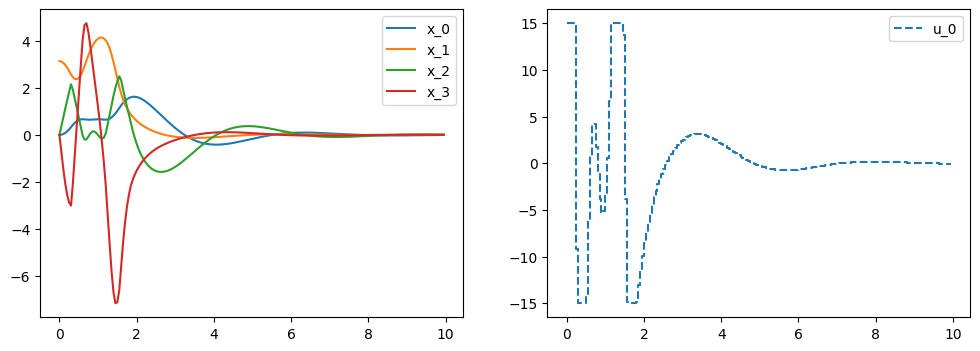

In [12]:
t_span = [0,10]
t_eval = np.arange(*t_span,dt)

x_init = casadi.DM([0,np.pi,0,0]) # x_initはx_sに名前を変えるか
# x0 = np.random.normal(scale=0.01,size=nx*(N+1)+nu*N) # 全部0でも良いがcasadi.DMで与えるべき
x0 = casadi.DM.zeros(total)

I = make_integrator()

X = [x_init]
U = []
x_current = x_init
for t in t_eval:
    u_opt,x0 = compute_optimal_control(S,x_current,x0)
    x_current = I(x0=x_current,p=u_opt)["xf"] # integratorに置き換える
    X.append(x_current)
    U.append(u_opt)

X.pop()
X = np.array(X).reshape(t_eval.size,nx)
U = np.array(U).reshape(t_eval.size,nu)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
for k in range(nx):
    plt.plot(t_eval,X[:,k],label=f"x_{k}")
plt.legend()

plt.subplot(1,2,2)
for k in range(nu):
    plt.step(t_eval,U[:,k],linestyle="--",label=f"u_{k}")
plt.legend()

plt.show()

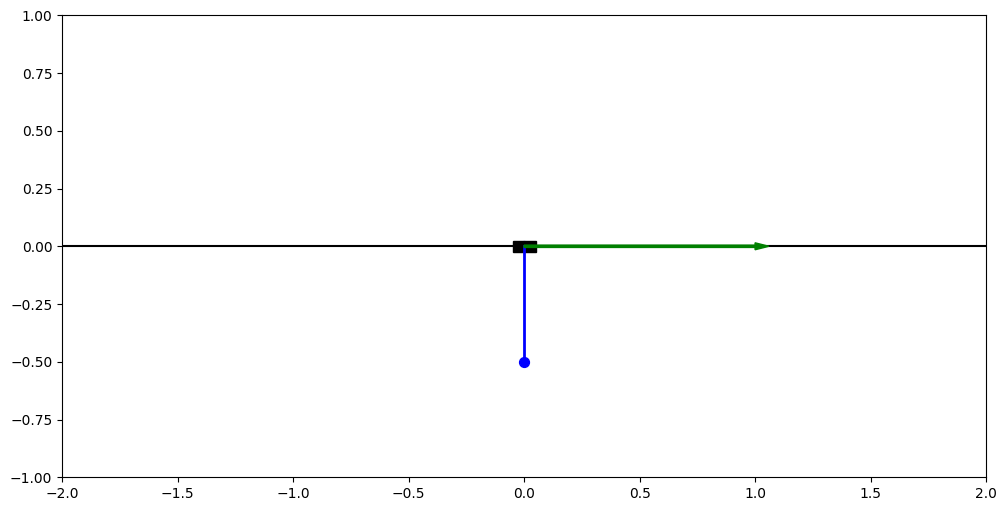

In [13]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
frames = np.arange(0,t_eval.size) # 200べた書き
fps = 1 / dt

def update_figure(i):
    x_lim_min = -2
    x_lim_max = 2
    y_lim_min = -1
    y_lim_max = 1
    u_scale = 15

    ax.cla()
    ax.set_xlim(x_lim_min, x_lim_max)
    ax.set_ylim(y_lim_min, y_lim_max)
    ax.set_aspect("equal")

    x,theta,_,_ = X[i]
    u, = U[i]

    points = np.array([
        [x,x-l*np.sin(theta)],
        [0,l*np.cos(theta)]
    ])

    ax.hlines(0,x_lim_min,x_lim_max,colors="black")
    ax.scatter(*points,color="blue", s=50)
    ax.plot(*points, color='blue', lw=2)
    ax.arrow(x,0,u/u_scale,0,width=0.01,head_width=0.03,head_length=0.06,length_includes_head=False,color="green",zorder=3)

    w = 0.1
    h = 0.05
    rect = patches.Rectangle(xy=(x-w/2,-h/2), width=w, height=h,color="black")
    ax.add_patch(rect)

ani = FuncAnimation(fig, update_figure, frames=frames)
ani.save("cart-pole_0.gif",writer="pillow",fps=fps)